In [13]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [41]:
HUE_ORDER = ["bind-9.18.4", "unbound-1.16.0", "unbound-1.10.0", "powerDNS-4.7.0", "powerDNS-4.7.3"]

In [42]:
def generate_subplots(dfs, title, x_label, y_label, row_annots, col_annots, hue_order=HUE_ORDER):
    """ Generates a plot for each dataframe specified 
    
    Arguments
        dfs: list of dataframes containing the data
        title: string describing all plots
        x_label: string describing the x label
        y_label: string describing the y label
        row_annots: list of strings, one to annotate each row of plots
        col_annots: list of strings, one to annotate each column of plots
    """
    n_cols = len(col_annots)
    n_rows = len(row_annots)
    n_plots = len(dfs)
    figure, axis = plt.subplots(ncols=n_cols, nrows=n_rows, sharey=True, sharex=True, figsize=(5*n_cols,5*n_rows))
    figure.suptitle(title, fontsize=20)
    pad = 5
    if axis.ndim < 2:
        axis = axis.reshape(1, 2)
    for ax, col in zip(axis[0], col_annots):
        ax.annotate(col, xy=(0.5, 1), xytext=(0, pad),
                    xycoords='axes fraction', textcoords='offset points',
                    size='large', ha='center', va='baseline')
    
    for ax, row in zip(axis[:,0], row_annots):
        ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                    xycoords=ax.yaxis.label, textcoords='offset points',
                    size='large', ha='right', va='center')

    axis = axis.flatten()
    for i in range(n_plots):
        sns.lineplot(x="x", y="y", hue="hue", hue_order=hue_order, data=dfs[i], marker="o", ax=axis[i])
        axis[i].set_xlabel(x_label)
        axis[i].set_ylabel(y_label)
    handles, labels = axis[0].get_legend_handles_labels()
    figure.legend(handles, labels, loc='upper left')
    for i in range(n_plots):
        axis[i].get_legend().remove()
    figure.tight_layout()

In [43]:
def convert_data_from_lukas_to_jodok_format(df, x_name, y_names):
    data_x = []
    data_hue = []
    data_y = []
    for i in range(len(y_names)):
        x = df[x_name]
        y = df[y_names[i]]
        hue = [y_names[i] for _ in range(len(x))]
        data_x.extend(x)
        data_y.extend(y)
        data_hue.extend(hue)
    df_new = pd.DataFrame(
        data={
            'x': data_x,
            'y': data_y,
            'hue': data_hue
        })
    df_new['hue'] = df_new['hue'].map({
            "BIND 9.18.4": "bind-9.18.4",
            "Unbound 1.16.0": "unbound-1.16.0",
            "PowerDNS 4.7.0": "powerDNS-4.7.0"
        })
    return df_new

In [44]:
def map_implementation_names(df):
    df['hue'] = df['hue'].map({
            "PowerDNS 4.7.3": "powerDNS-4.7.x"
        })
    return df

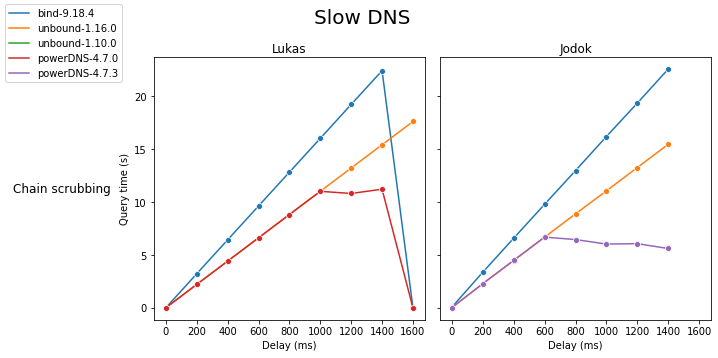

In [45]:
dfs_slowDNS = [
    convert_data_from_lukas_to_jodok_format(
        pd.read_csv("results_lukas/delay_cname_validation/delayed_cname_validation.csv"),
        "Delay (ms)",
        ['BIND 9.18.4', 'Unbound 1.16.0', 'PowerDNS 4.7.0']
    ),
    pd.read_csv("slowDNS+CNAME+Scrubbing/data.csv")
]
generate_subplots(
    dfs_slowDNS,
    "Slow DNS",
    "Delay (ms)",
    "Query time (s)",
    ["Chain scrubbing"],
    ["Lukas", "Jodok"]
)

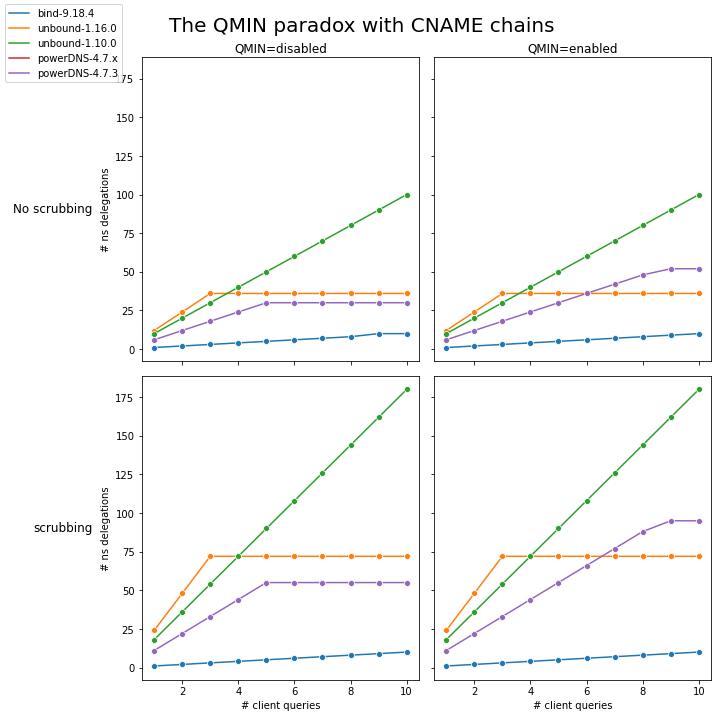

In [38]:
dfs_subquery = [
    pd.read_csv("subquery+CNAME_QMIN=disabled/data.csv"),
    pd.read_csv("subquery+CNAME_QMIN=enabled/data.csv"),
    pd.read_csv("subquery+CNAME+scrubbing_QMIN=disabled/data.csv"),
    pd.read_csv("subquery+CNAME+scrubbing_QMIN=enabled/data.csv")
]
generate_subplots(
    dfs_subquery,
    "The QMIN paradox with CNAME chains",
    "# client queries",
    "# ns delegations",
    ["No scrubbing", "scrubbing"],
    ["QMIN=disabled", "QMIN=enabled"]
)

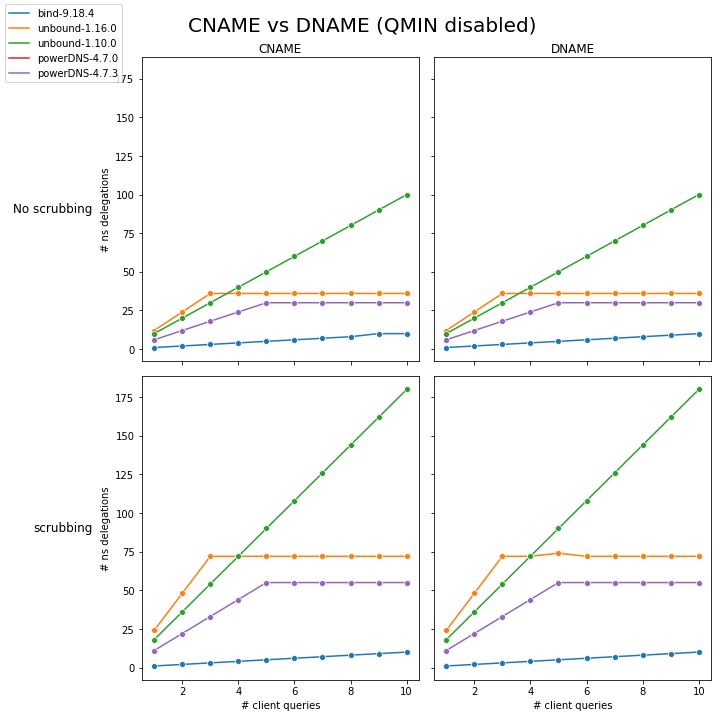

In [12]:
dfs_subquery = [
    pd.read_csv("subquery+CNAME_QMIN=disabled/data.csv"),
    pd.read_csv("subquery+DNAME_QMIN=disabled/data.csv"),
    pd.read_csv("subquery+CNAME+scrubbing_QMIN=disabled/data.csv"),
    pd.read_csv("subquery+DNAME+scrubbing_QMIN=disabled/data.csv")
]
generate_subplots(
    dfs_subquery,
    "CNAME vs DNAME (QMIN disabled)",
    "# client queries",
    "# ns delegations",
    ["No scrubbing", "scrubbing"],
    ["CNAME", "DNAME"]
)

In [20]:
dfs_subquery[3][dfs_subquery[3].hue=="powerDNS-4.7.3"]

,hue,y,x
3,powerDNS-4.7.3,22,1
7,powerDNS-4.7.3,44,2
11,powerDNS-4.7.3,66,3
15,powerDNS-4.7.3,88,4
19,powerDNS-4.7.3,95,5
22,powerDNS-4.7.3,95,6
27,powerDNS-4.7.3,95,7
31,powerDNS-4.7.3,95,8
35,powerDNS-4.7.3,95,9
39,powerDNS-4.7.3,95,10


In [ ]:
def create_combined_plots_simple(list_list_values, filename, implementation_names, folder_path):

    x = range(1, len(list_list_values[0])+1)
    fig = plt.figure()
    ax = fig.add_subplot()

    missing_attributes = []
    ns_del = 0
    cname_chain_length= 0
    nb_labels = 0

    x_labels = "TOBEDEFINED"

    ax.set_xlabel(x_labels, fontsize = 12)
    ax.set_ylabel('Amplification factor', fontsize = 12)

    ax.set_xlim(0,10+1)
    ax.set_ylim(0, 1700)

    fixed_vars = {"ns_del" : "#Del={}".format(str(ns_del)), "cname_chain_length" : "CNAME_length={}".format(str(cname_chain_length)), "nb_labels" : "#Labels={}".format(str(nb_labels))}
    fixed = [fixed_vars[i] for i in fixed_vars.keys()]
    vars = ", ".join(fixed)
    # RElated to the previous : find from the filename what are the fixed attributes
    ax.set_title('Amplification factor c/nameserver with Sub+CCV+QMIN \n Fixed values : {vars}'.format(vars=vars), fontsize = 11)

    ax.grid()
    for list_values in list_list_values:
        ax.plot(x, list_values, marker = 'o')


    plot_path = folder_path+"fig_"+filename.split(".")[0]+".jpg"
    
    # remove the previous path
    if os.path.exists(plot_path):
        os.remove(plot_path)
        #print("removed plot")
        
    

    for i in range(0,len(implementation_names)):
        list_values = list_list_values[i]
        max_point_annot(x,list_values, implementation_names[i], i/len(list_list_values))

    plt.legend(implementation_names)

    plt.savefig(plot_path)
    plt.close()
